In [1]:
# default_exp surface

# Estimation of Price & Carbon Intensity Surfaces

<br>

### Imports

In [2]:
#exports
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import os
import pickle
import FEAutils as hlp
from ipypb import track

from moepy import lowess, eda

<br>

### User Inputs

In [3]:
models_dir = '../data/models'
load_existing_model = True

<br>

### Loading & Cleaning Data

In [4]:
%%time

df_EI = eda.load_EI_df('../data/electric_insights.csv')

df_EI.head()

Wall time: 4.97 s


,day_ahead_price,SP,imbalance_price,valueSum,temperature,TCO2_per_h,gCO2_per_kWh,nuclear,biomass,coal,...,demand,pumped_storage,wind_onshore,wind_offshore,belgian,dutch,french,ireland,northern_ireland,irish
local_datetime,,,,,,,,,,,,,,,,,,,,,
2009-01-01 00:00:00+00:00,58.05,1,74.74,74.74,-0.6,21278.0,555.0,6.973,0.0,17.650,...,38.329,-0.404,NaN,NaN,0.0,0.0,1.977,0.0,0.0,-0.161
2009-01-01 00:30:00+00:00,56.33,2,74.89,74.89,-0.6,21442.0,558.0,6.968,0.0,17.770,...,38.461,-0.527,NaN,NaN,0.0,0.0,1.977,0.0,0.0,-0.160
2009-01-01 01:00:00+00:00,52.98,3,76.41,76.41,-0.6,21614.0,569.0,6.970,0.0,18.070,...,37.986,-1.018,NaN,NaN,0.0,0.0,1.977,0.0,0.0,-0.160
2009-01-01 01:30:00+00:00,50.39,4,37.73,37.73,-0.6,21320.0,578.0,6.969,0.0,18.022,...,36.864,-1.269,NaN,NaN,0.0,0.0,1.746,0.0,0.0,-0.160
2009-01-01 02:00:00+00:00,48.70,5,59.00,59.00,-0.6,21160.0,585.0,6.960,0.0,17.998,...,36.180,-1.566,NaN,NaN,0.0,0.0,1.730,0.0,0.0,-0.160


Text(0, 0.5, 'Price (£/MWh)')

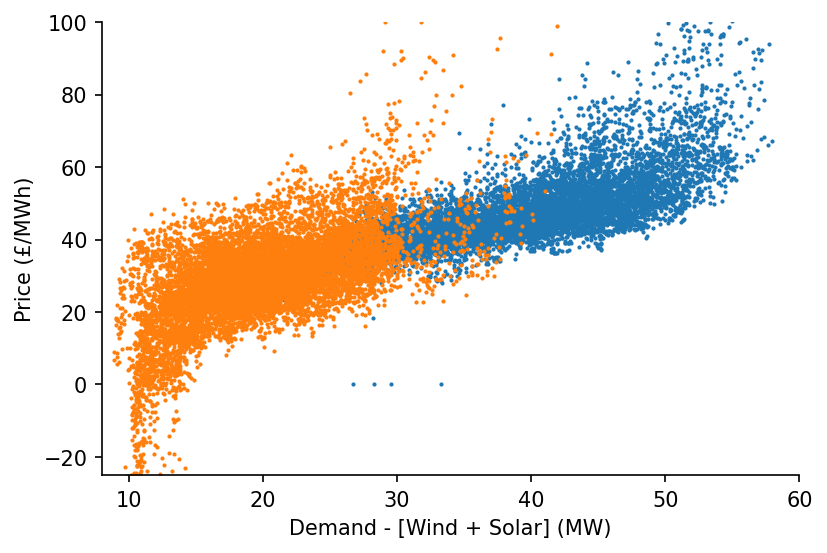

In [5]:
df_EI_model = df_EI[['day_ahead_price', 'demand', 'solar', 'wind']].dropna()

s_demand = df_EI_model['demand']
s_price = df_EI_model['day_ahead_price']
s_dispatchable = df_EI_model['demand'] - df_EI_model[['solar', 'wind']].sum(axis=1)

# Plotting
fig, ax = plt.subplots(dpi=150)

ax.scatter(s_dispatchable['2010-09':'2011-03'], s_price['2010-09':'2011-03'], s=1)
ax.scatter(s_dispatchable['2020-03':'2020-09'], s_price['2020-03':'2020-09'], s=1)

hlp.hide_spines(ax)
ax.set_xlim(8, 60)
ax.set_ylim(-25, 100)
ax.set_xlabel('Demand - [Wind + Solar] (MW)')
ax.set_ylabel('Price (£/MWh)')

In [11]:
df_DE = eda.load_DE_df('../data/energy_charts.csv', '../data/ENTSOE_DE_price.csv')

df_DE.head()

,Biomass,Brown Coal,Gas,Hard Coal,Hydro Power,Oil,Others,Pumped Storage,Seasonal Storage,Solar,Uranium,Wind,net_balance,demand,price
local_datetime,,,,,,,,,,,,,,,
2010-01-03 23:00:00+00:00,3.637,16.533,4.726,10.078,2.331,0.000,0.0,0.052,0.068,0.0,16.826,0.635,-1.229,53.657,NaN
2010-01-04 00:00:00+00:00,3.637,16.544,4.856,8.816,2.293,0.000,0.0,0.038,0.003,0.0,16.841,0.528,-1.593,51.963,NaN
2010-01-04 01:00:00+00:00,3.637,16.368,5.275,7.954,2.299,0.000,0.0,0.032,0.000,0.0,16.846,0.616,-1.378,51.649,NaN
2010-01-04 02:00:00+00:00,3.637,15.837,5.354,7.681,2.299,0.000,0.0,0.027,0.000,0.0,16.699,0.630,-1.624,50.540,NaN
2010-01-04 03:00:00+00:00,3.637,15.452,5.918,7.498,2.301,0.003,0.0,0.020,0.000,0.0,16.635,0.713,-0.731,51.446,NaN


Text(0, 0.5, 'Price (£/MWh)')

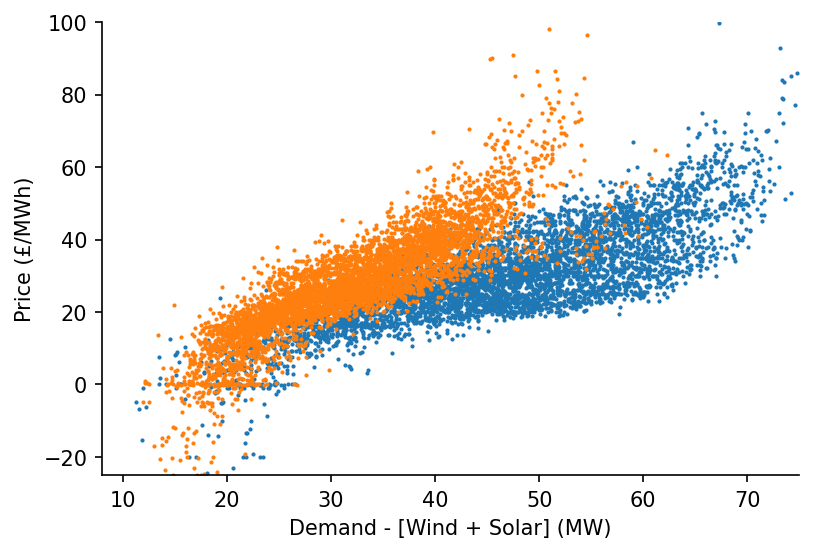

In [15]:
df_DE_model = df_DE[['price', 'demand', 'Solar', 'Wind']].dropna()

s_DE_demand = df_DE_model['demand']
s_DE_price = df_DE_model['price']
s_DE_dispatchable = df_DE_model['demand'] - df_DE_model[['Solar', 'Wind']].sum(axis=1)

# Plotting
fig, ax = plt.subplots(dpi=150)

ax.scatter(s_DE_dispatchable['2015-09':'2016-03'], s_DE_price['2015-09':'2016-03'], s=1)
ax.scatter(s_DE_dispatchable['2020-03':'2020-09'], s_DE_price['2020-03':'2020-09'], s=1)

hlp.hide_spines(ax)
ax.set_xlim(8, 75)
ax.set_ylim(-25, 100)
ax.set_xlabel('Demand - [Wind + Solar] (MW)')
ax.set_ylabel('Price (£/MWh)')

<br>

### Hyper-Parameter Tuning

In [6]:
# should use skopt wrapper from smart meter modelling
# this section should be saved to the module but not run in the main pipeline

<br>

### Results Wrapper

In [22]:
#exports
import copy
import types
import marshal

class PicklableFunction:
    def __init__(self, fun):
        self._fun = fun

    def __call__(self, *args, **kwargs):
        return self._fun(*args, **kwargs)

    def __getstate__(self):
        try:
            return pickle.dumps(self._fun)
        except Exception:
            return marshal.dumps((self._fun.__code__, self._fun.__name__))

    def __setstate__(self, state):
        try:
            self._fun = pickle.loads(state)
        except Exception:
            code, name = marshal.loads(state)
            self._fun = types.FunctionType(code, {}, name)
            
        return
          
def get_fit_kwarg_sets(qs=np.linspace(0.1, 0.9, 9)):
    fit_kwarg_sets = [
        # quantile lowess
        { 
            'name': f'p{int(q*100)}',
            'lowess_kwargs': {'reg_func': PicklableFunction(lowess.calc_quant_reg_betas)},
            'q': q,
        }
        for q in qs

        # standard lowess
    ] + [{'name': 'average'}] 
    
    return fit_kwarg_sets

In [31]:
model_definitions = {
    'DAM_price_GB': {
        'dt_idx': s_dispatchable.index,
        'x': s_dispatchable.values,
        'y': s_price.values,
        'reg_dates_start': '2009-01-01',
        'reg_dates_end': '2021-01-01',
        'reg_dates_freq': '13W', # 13 
        'frac': 0.3, 
        'num_fits': 31, # 31
        'dates_smoothing_value': 26, # 26
        'dates_smoothing_units': 'W',
        'fit_kwarg_sets': get_fit_kwarg_sets(qs=[0.16, 0.5, 0.84])
    },
    'DAM_price_demand_GB': {
        'dt_idx': s_demand.index,
        'x': s_demand.values,
        'y': s_price.values,
        'reg_dates_start': '2009-01-01',
        'reg_dates_end': '2021-01-01',
        'reg_dates_freq': '13W', # 13 
        'frac': 0.3, 
        'num_fits': 31, # 31
        'dates_smoothing_value': 26, # 26
        'dates_smoothing_units': 'W',
        'fit_kwarg_sets': get_fit_kwarg_sets(qs=[0.5])
    },
    'DAM_price_DE': {
        'dt_idx': s_DE_dispatchable.index,
        'x': s_DE_dispatchable.values,
        'y': s_DE_price.values,
        'reg_dates_start': '2015-01-04',
        'reg_dates_end': '2021-01-01',
        'reg_dates_freq': '13W', # 13 
        'frac': 0.3, 
        'num_fits': 31, # 31
        'dates_smoothing_value': 26, # 26
        'dates_smoothing_units': 'W',
        'fit_kwarg_sets': get_fit_kwarg_sets(qs=[0.16, 0.5, 0.84])
    },
    'DAM_price_demand_DE': {
        'dt_idx': s_DE_dispatchable.index,
        'x': s_DE_demand.values,
        'y': s_DE_price.values,
        'reg_dates_start': '2015-01-04',
        'reg_dates_end': '2021-01-01',
        'reg_dates_freq': '13W', # 13 
        'frac': 0.3, 
        'num_fits': 31, # 31
        'dates_smoothing_value': 26, # 26
        'dates_smoothing_units': 'W',
        'fit_kwarg_sets': get_fit_kwarg_sets(qs=[0.5])
    }
}

In [28]:
# Should make it so that model_defs are JSON parseable and can be stored as a yaml
# Can map from strings to parameterised funcs within the `fit_models` wrapper
# create the dispatchable column as part of a feature generation step within `retrieval`

In [29]:
#exports
def fit_models(model_definitions, models_dir):
    for model_parent_name, model_spec in model_definitions.items():
        for fit_kwarg_set in track(model_spec['fit_kwarg_sets'], label=model_parent_name):
            run_name = fit_kwarg_set.pop('name')
            model_name = f'{model_parent_name}_{run_name}'

            if f'{model_name}.pkl' not in os.listdir(models_dir):
                smooth_dates = lowess.SmoothDates()

                reg_dates = pd.date_range(
                    model_spec['reg_dates_start'], 
                    model_spec['reg_dates_end'], 
                    freq=model_spec['reg_dates_freq']
                )
                
                smooth_dates.fit(
                    model_spec['x'], 
                    model_spec['y'], 
                    dt_idx=model_spec['dt_idx'], 
                    reg_dates=reg_dates, 
                    frac=model_spec['frac'], 
                    threshold_value=model_spec['dates_smoothing_value'], 
                    threshold_units=model_spec['dates_smoothing_units'],
                    num_fits=model_spec['num_fits'], 
                    **fit_kwarg_set
                )
                
                model_fp = f'{models_dir}/{model_name}.pkl'
                pickle.dump(smooth_dates, open(model_fp, 'wb'))

                del smooth_dates

In [30]:
fit_models(model_definitions, models_dir)

      DAM_price [█████████████████████████████████████████████] 4/4 [03:09:29<00:00, 2842.24s/it]

 [████████████████████████████████████████████████████████████] 49/49 [01:33:10<01:58, 114.08s/it]

 [████████████████████████████████████████████████████████████] 49/49 [01:35:60<02:06, 117.54s/it]

DAM_price_deman [█████████████████████████████████████████████] 10/10 [00:00<00:00, 0.00s/it]

   DAM_price_DE [█████████████████████████████████████████████] 4/4 [07:40<00:00, 114.95s/it]

 [████████████████████████████████████████████████████████████] 25/25 [04:33<00:10, 10.91s/it]

 [████████████████████████████████████████████████████████████] 25/25 [03:05<00:06, 7.40s/it]

DAM_price_deman [█████████████████████████████████████████████] 1/1 [00:32<00:32, 31.54s/it]

 [████████████████████████████████████████████████████████████] 25/25 [00:31<00:01, 1.23s/it]

In [32]:
fit_models(model_definitions, models_dir)

      DAM_price [█████████████████████████████████████████████] 4/4 [00:00<00:00, 0.00s/it]

DAM_price_deman [█████████████████████████████████████████████] 10/10 [00:00<00:00, 0.00s/it]

   DAM_price_DE [█████████████████████████████████████████████] 4/4 [00:00<00:00, 0.00s/it]

DAM_price_deman [█████████████████████████████████████████████] 2/2 [06:12<00:00, 186.20s/it]

 [████████████████████████████████████████████████████████████] 25/25 [06:11<00:15, 14.86s/it]

In [11]:
%%time

if load_existing_model == True:
    smooth_dates = pickle.load(open(f'{models_dir}/DAM_price_p50.pkl', 'rb'))
else:
    lowess_kwargs = {}
    reg_dates = pd.date_range('2009-01-01', '2021-01-01', freq='13W')

    smooth_dates = lowess.SmoothDates()
    smooth_dates.fit(s_dispatchable.values, s_price.values, dt_idx=s_dispatchable.index, 
                     reg_dates=reg_dates, frac=0.3, num_fits=31, threshold_value=26, lowess_kwargs=lowess_kwargs)

Wall time: 5.48 s


In [12]:
%%time

x_pred = np.linspace(8, 60, 521)
dt_pred = pd.date_range('2009-01-01', '2021-01-01', freq='1W')

df_pred = smooth_dates.predict(x_pred=x_pred, dt_pred=dt_pred)

df_pred.head()

Wall time: 332 ms


,2009-01-04,2009-01-11,2009-01-18,2009-01-25,2009-02-01,2009-02-08,2009-02-15,2009-02-22,2009-03-01,2009-03-08,...,2020-10-25,2020-11-01,2020-11-08,2020-11-15,2020-11-22,2020-11-29,2020-12-06,2020-12-13,2020-12-20,2020-12-27
8.0,-7.660008,-7.789268,-7.910814,-8.025717,-8.134805,-8.238751,-8.338129,-8.433449,-8.525193,-8.613820,...,10.235374,10.292018,10.347611,10.402138,10.455693,10.508530,10.561129,10.614270,10.669140,10.727071
8.1,-7.467721,-7.596370,-7.717343,-7.831705,-7.940282,-8.043744,-8.142661,-8.237542,-8.328865,-8.417088,...,10.442911,10.499384,10.554824,10.609219,10.662661,10.715403,10.767921,10.820990,10.875787,10.933636
8.2,-7.275607,-7.403641,-7.524036,-7.637854,-7.745917,-7.848890,-7.947342,-8.041780,-8.132678,-8.220493,...,10.650337,10.706638,10.761927,10.816190,10.869521,10.922169,10.974607,11.027605,11.082331,11.140099
8.3,-7.083662,-7.211075,-7.330889,-7.444158,-7.551701,-7.654183,-7.752166,-7.846157,-7.936627,-8.024030,...,10.857636,10.913767,10.968906,11.023039,11.076259,11.128814,11.181173,11.234100,11.288756,11.346444
8.4,-6.891877,-7.018666,-7.137894,-7.250611,-7.357631,-7.459617,-7.557128,-7.650668,-7.740706,-7.827694,...,11.064795,11.120757,11.175747,11.229751,11.282861,11.335324,11.387606,11.440464,11.495050,11.552659
